# FRiP

Plots for single-cell fraction of reads in peak sets (FRiP). In this subfigure, would plot the FRiP in iPSC peaks and Fibroblast peaks.

Inputs:

1. `metadata.tsv` with UMAP/densMAP coordinates and total fragments/insertions.
2. Single-cell counts matrix derived from snapATAC with corresponding peaks.
3. Peak sets with Fibroblast and iPSC peaks.

In [1]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [4]:
# this is a kludge for now, clusters AND total insertions should also be present in same metaData as above
snapATAC_metaData = read.table("../../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
metaData$total_insertions = snapATAC_metaData[rownames(metaData), "TN"] 
head(metaData)

,barcode,sample,umap1,umap2,cells,cluster,total_insertions
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>,<int>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5,53446
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5,27136
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5,23308
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6,18466
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5,3238
D0_AAACACGCTCGAGTGA,AAACACGCTCGAGTGA,D0,3.408866,-9.058377,D0_AAACACGCTCGAGTGA,6,50468


### Insertions Count Matrix + Regions

In [5]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 409052

In [6]:
peak_regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 409052      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10355_10867,chr1,10355,10867,chr1_10355_10867
chr1_41995_42521,chr1,41995,42521,chr1_41995_42521
chr1_46067_46593,chr1,46067,46593,chr1_46067_46593
chr1_48475_48975,chr1,48475,48975,chr1_48475_48975
chr1_51286_52235,chr1,51286,52235,chr1_51286_52235
chr1_58648_59148,chr1,58648,59148,chr1_58648_59148


In [7]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [8]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 12150

In [9]:
pmatRowSums = Matrix::rowSums(pmat)

In [10]:
# these values should correlate well (reads in peaks vs total reads)
cor(pmatRowSums, metaData$total_insertions, method='spearman')

[1] 0.9899533

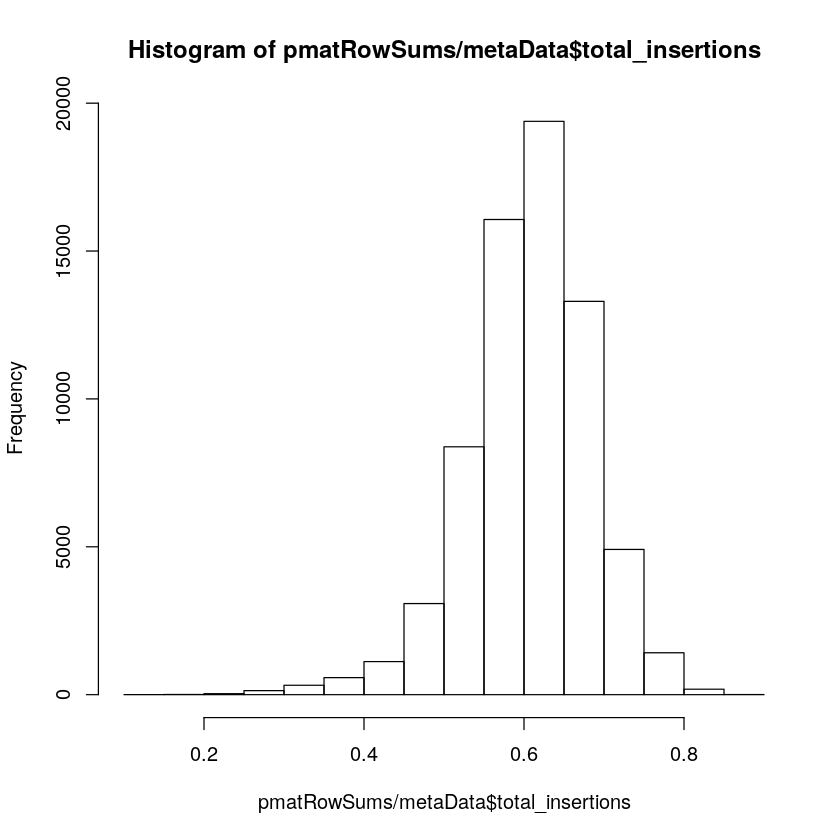

In [11]:
hist(pmatRowSums/metaData$total_insertions)

### Peak Sets

In [12]:
fibroblast_peaks = read.table("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bulk/croo/D0/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
fibroblast_peaks = fibroblast_peaks[,1:3]
colnames(fibroblast_peaks) = c("chr", "start", "end")
fibroblast_peaks = makeGRangesFromDataFrame(fibroblast_peaks)
fibroblast_peaks

GRanges object with 234319 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   16612604-16614026      *
       [2]     chr9   62801935-62802834      *
       [3]     chr1   16643948-16645198      *
       [4]     chr7   75156323-75157647      *
       [5]     chr7   44606345-44607283      *
       ...      ...                 ...    ...
  [234315]    chr19   18044857-18045395      *
  [234316]     chr7 100478378-100479635      *
  [234317]     chr3 119293671-119295459      *
  [234318]     chr9 121246836-121247679      *
  [234319]     chr5   96388058-96388641      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [13]:
iPSC_peaks = read.table("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bulk/croo/iPSC/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
iPSC_peaks = iPSC_peaks[,1:3]
colnames(iPSC_peaks) = c("chr", "start", "end")
iPSC_peaks = makeGRangesFromDataFrame(iPSC_peaks)
iPSC_peaks

GRanges object with 212222 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   16613198-16614044      *
       [2]     chr1   16921296-16922343      *
       [3]     chr5 146202982-146204059      *
       [4]    chr17   46578959-46580344      *
       [5]     chr5   43312856-43313973      *
       ...      ...                 ...    ...
  [212218]     chr1 171898876-171899563      *
  [212219]     chr1 171245315-171245948      *
  [212220]     chr1 150221350-150222043      *
  [212221]     chr1   13929937-13930647      *
  [212222]     chr1 115564038-115564865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Plotting

### Fibroblast Peak Set

In [14]:
peak_intersect_fibr = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))]
peak_intersect_fibr

GRanges object with 87589 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     196313-196826      *
      [2]     chr1     778151-779381      *
      [3]     chr1     817132-819324      *
      [4]     chr1     826576-828254      *
      [5]     chr1     850263-850797      *
      ...      ...               ...    ...
  [87585]     chrY 19076751-19078278      *
  [87586]     chrY 19559113-19559854      *
  [87587]     chrY 19566561-19568390      *
  [87588]     chrY 19744052-19745462      *
  [87589]     chrY 20574883-20576318      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [16]:
# dividing by total insertions doesn't give a clean signal for iPSC peaks, D12/14 have overall low fraction of reads in peaks

# reads_in_fibr_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))])/metaData$total_insertions
reads_in_fibr_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))])/pmatRowSums

In [17]:
min(reads_in_fibr_peaks)
median(reads_in_fibr_peaks)
max(reads_in_fibr_peaks)

[1] 0.3180259

[1] 0.6782616

[1] 0.9335586

In [18]:
cor(reads_in_fibr_peaks, metaData$total_insertions, method='spearman')

[1] -0.02497013

In [33]:
plot_df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                percent_reads=reads_in_fibr_peaks)
# shuffle so days don't overlap
plot_df = plot_df[sample(dim(plot_df)[1]), ]


fibr_frip <- ggplot(plot_df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
    scale_color_viridis_c(limits=c(quantile(reads_in_fibr_peaks, 0.1), 
                               quantile(reads_in_fibr_peaks, 0.99)), 
                      oob=squish,
                          name="Normalized\nInsertions", 
                          option = "B") +
    ggtitle(sprintf("Insertions in Fibroblast Peaks \n (%d Mbp)",  
               as.integer(sum(width(peak_intersect_fibr))/1e6))) + 
    theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

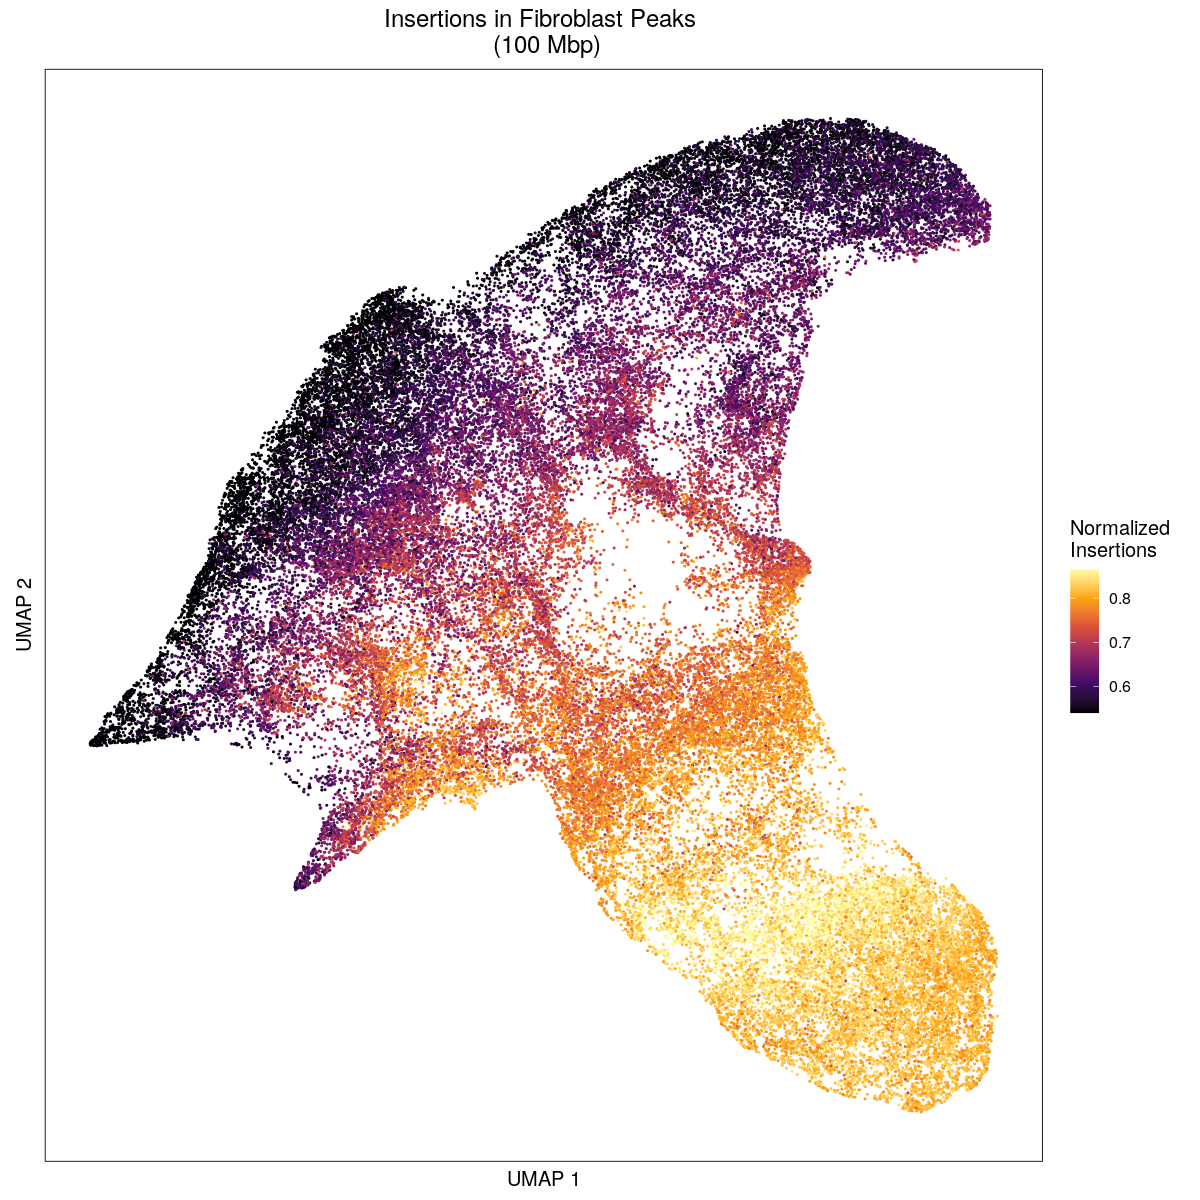

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)
fibr_frip

In [35]:
saveRDS(fibr_frip, file=sprintf("subfigs/%s_fibroblast_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [21]:
ggsave("tmp.png", fibr_frip, height=10, width=10)

### iPSC Peak Set

In [22]:
peak_intersect_ipsc = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))]
peak_intersect_ipsc

GRanges object with 90930 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     778151-779381      *
      [2]     chr1     826576-828254      *
      [3]     chr1     857838-859141      *
      [4]     chr1     869645-870446      *
      [5]     chr1     904198-905035      *
      ...      ...               ...    ...
  [90926]     chrY   5002705-5003225      *
  [90927]     chrY   5215065-5215995      *
  [90928]     chrY   5708657-5710502      *
  [90929]     chrY   6130651-6131328      *
  [90930]     chrY 12438681-12439412      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [23]:
# dividing by total insertions doesn't give a clean signal for iPSC peaks, D12/14 have overall low fraction of reads in peaks

# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/pmatRowSums

In [24]:
min(reads_in_ipsc_peaks)
median(reads_in_ipsc_peaks)
max(reads_in_ipsc_peaks)

[1] 0.2858163

[1] 0.6011219

[1] 0.8788793

In [36]:
plot_df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                percent_reads=reads_in_ipsc_peaks)
# shuffle so days don't overlap
plot_df = plot_df[sample(dim(plot_df)[1]), ]


ipsc_frip <- ggplot(plot_df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
    scale_color_viridis_c(limits=c(quantile(reads_in_ipsc_peaks, 0.1), 
                               quantile(reads_in_ipsc_peaks, 0.99)), 
                      oob=squish,
                          name="Normalized\nInsertions", 
                          option = "B") +
    ggtitle(sprintf("Insertions in iPSC Peaks \n (%d Mbp)",  
               as.integer(sum(width(peak_intersect_ipsc))/1e6))) + 
    theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

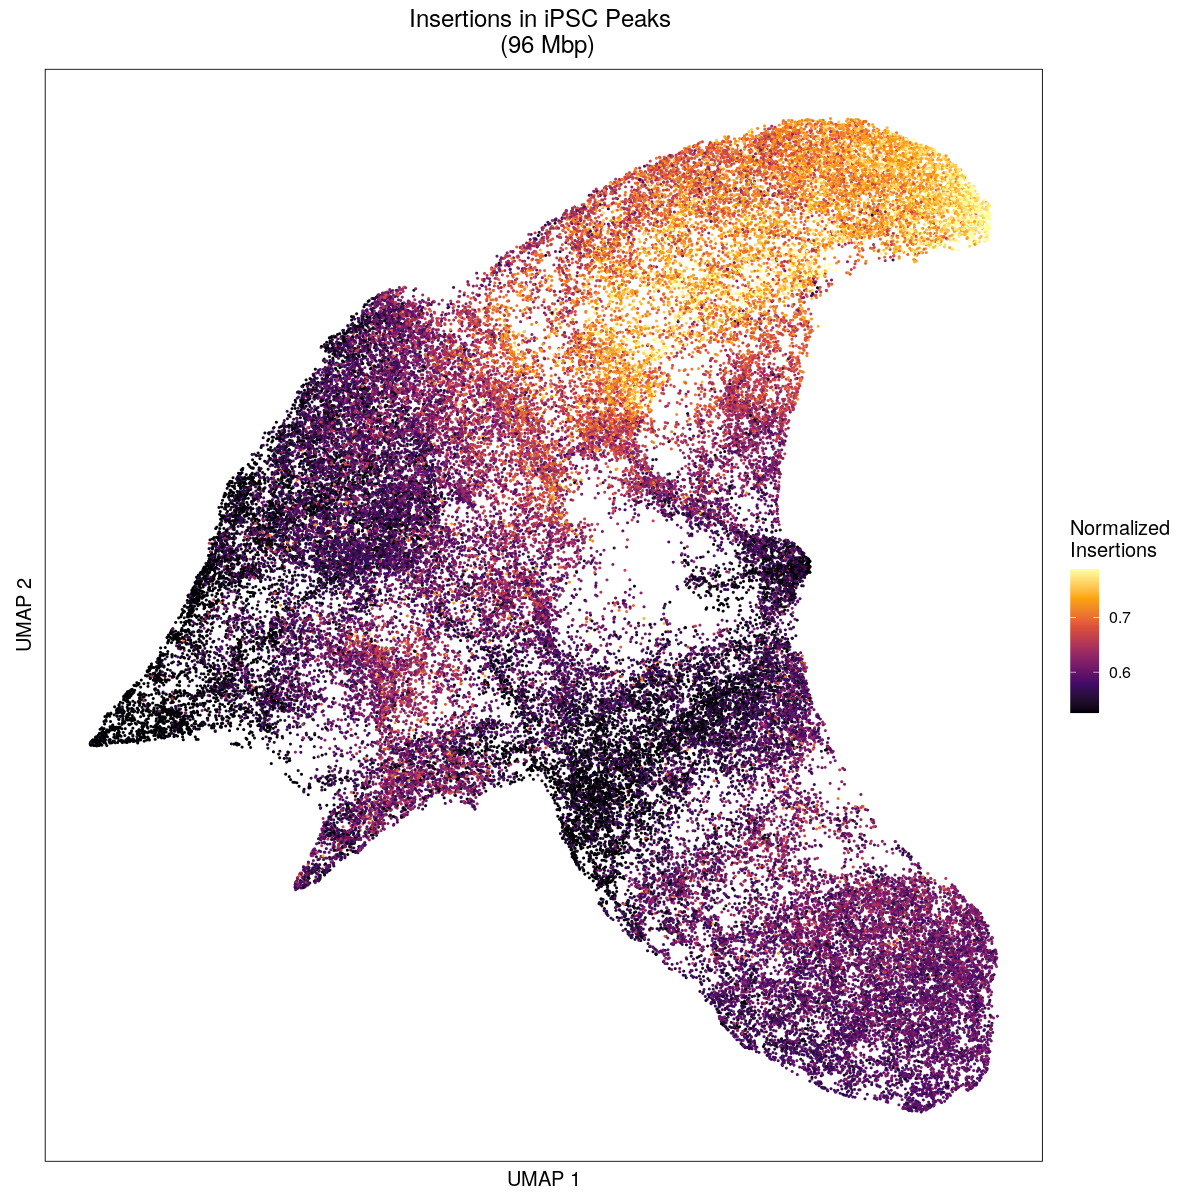

In [37]:
options(repr.plot.width = 10, repr.plot.height = 10)
ipsc_frip

In [38]:
saveRDS(ipsc_frip, file=sprintf("subfigs/%s_ipsc_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [220]:
ggsave("tmp.png", ipsc_frip, height=10, width=10)